# Code

In [117]:
using Random, Distributions, CSV, DataFrames, Plots, StatsPlots, Contour,
Dates, GLM, Pipe, Underscores,
Statistics, StatsBase, RollingFunctions, Optim;

function produce_olsβ(X, Y, ss)
    T = length(X)
    β = []
    for i in 1: (T - (ss - 1))
    x = X[i : (ss + i - 1)]
    y = Y[i : (ss + i - 1)]
    v = coef(lm([ones(length(x)) x], y))[2]
    push!(β, v)
    end
    return(β)
end

produce_olsβ (generic function with 1 method)

In [118]:
function simulate_data(σ, σx, T, ss, α, windowsize, c0, n0, θ0)
    Δnt = rand(Normal(0, σx), T)
    nt = []
    for i in 1:T
        v = sum(Δnt[1 : i]) + n0
        push!(nt, v)
    end
    Ut = rand(Normal(0, σ), T)
    θt = []
    push!(θt, θ0)
    for i in 1 : (T-1)
        v = θt[i] + α * sign(Δnt[i]) * Ut[i] / σ
        #v = θt[i] + α * (-1) * Ut[i] / σ
        push!(θt, v)
    end
    βt = 1 ./ (1 .+ exp.(-θt));
    Δct = βt .* Δnt + Ut;
    ct = []
    for i in 1:T
        v = sum(Δct[1 : i]) + c0
        push!(ct, v)
    end
    Nt = exp.(nt)
    Ct = exp.(ct)
    WindowNt = runmean(Nt, windowsize) * windowsize
    WindowCt = runmean(Ct, windowsize) * windowsize
    Windownt = log.(WindowNt)
    Windowct = log.(WindowCt)
    ΔWnt = Windownt .- lag(Windownt)
    ΔWct = Windowct .- lag(Windowct)
    Δ7ct = runmean(Δct, windowsize) * windowsize
    Δ7nt = runmean(Δnt, windowsize) * windowsize
    data = @pipe DataFrame(Nt = Nt[windowsize : end], Ct = Ct[windowsize : end],
                    Δnt = Δnt[windowsize : end], Δct = Δct[windowsize : end],
                    Δ7nt = Δ7nt[windowsize : end], Δ7ct = Δ7ct[windowsize : end],
                    ΔWnt = ΔWnt[windowsize : end], ΔWct = ΔWct[windowsize : end],
                    βt = βt[windowsize : end]) |>
            dropmissing(_)
    return(data)
end

βasθ(θ) = 1 / (1 + exp(-θ));

function recoverTheta1(par, x, y)
    T = length(x)
    ω = par[1]; 
    ϕ = par[2];
    α = par[3]; 
    σ = par[4];
    θ0 = par[5];
    θ = [];
    push!(θ, θ0)
    for i in 1:(T-1)
        #v = ω + ϕ * θ[i] + α * (1 / σ) * sign(x[i]) * ( y[i] - x[i] * βasθ(θ[i]) ) 
        v = ω + ϕ * θ[i] + α * (1 / σ) * (-1) * ( y[i] - x[i] * βasθ(θ[i]) ) 
        push!(θ, v)
    end
    return θ
end

function Ut1(par, x, y)
    θ = recoverTheta1(par, x, y );
    Ut = y .- x .* βasθ.(θ) 
end

function logL1(par, x, y)
    T = length(x)
    σ = par[4];
    Ut = Ut1(par, x, y)
    ll = - T * log(σ^2) / 2 - sum(Ut .^ 2)/(2 * σ^2)  
    return(ll)
end


logL1 (generic function with 1 method)

## Parameters

In [119]:
#Nstar = 5800000; # N*, to get adjusted cases numbers
#nstar = log(Nstar);
σ = 0.2
σx = 0.25
T = 10000
ss = 100
α = 0.05
windowsize = 7
c0 = log(10000)
n0 = log(1000000)
θ0 = 0
data = simulate_data(σ, σx, T, ss, α, windowsize, c0, n0, θ0);
daily_β = produce_olsβ(data.Δnt, data.Δct, ss);
dd_β = produce_olsβ(data.Δ7nt, data.Δ7ct, ss);
ww_β = produce_olsβ(data.ΔWnt, data.ΔWct, ss);
truncate_β = data.βt[Int(ss/2) - 1 : end - Int(ss/2)];

## Daily Score Estimation

In [120]:
## Daily Score
θ_initial = [α, σ]
first_θ = log(data.βt[1] / (1 - data.βt[1]))
restricted_logL(a, s) = -logL1([0, 1, a, s, first_θ], data.Δnt, data.Δct) 
obj = θ -> restricted_logL(θ[1], θ[2])
res = optimize(obj, θ_initial)
# Estimated static parameters
a, s = Optim.minimizer(res)
score_β = βasθ.(recoverTheta1([0, 1, a, s, first_θ], data.Δnt, data.Δct))
scorep1 = plot(score_β, color = :red, label = "daily score βt")
          plot!(data.βt, color = :black, label = "real βt", leg = :bottomleft)
a


0.011283806271414436

In [121]:
s

0.20577131067099913

## 7DD Score Estimation

In [122]:
θ_initial = [α, σ]
restricted_logL(a, s) = -logL1([0, 1, a, s, first_θ], data.Δ7nt, data.Δ7ct) 
obj = θ -> restricted_logL(θ[1], θ[2])
res = optimize(obj, θ_initial)
  # Estimated static parameters
a, s = Optim.minimizer(res)
score_β = βasθ.(recoverTheta1([0, 1, a, s, first_θ], data.Δ7nt, data.Δ7ct))
scorep2 = plot(score_β, color = :red, label = "7DD score βt")
          plot!(data.βt, color = :black, label = "real βt")
a


0.004294336753434554

In [123]:
s

0.5518612138404597

## Weekly Score Estimation

In [124]:
θ_initial = [α, σ]
restricted_logL(a, s) = -logL1([0, 1, a, s, first_θ], data.ΔWnt, data.ΔWct) 
obj = θ -> restricted_logL(θ[1], θ[2])
res = optimize(obj, θ_initial)
  # Estimated static parameters
a, s = Optim.minimizer(res)
score_β = βasθ.(recoverTheta1([0, 1, a, s, first_θ], data.ΔWnt, data.ΔWct))
scorep3 = plot(score_β, color = :red, label = "Weekly score βt")
          plot!(data.βt, color = :black, label = "real βt")
a


0.004528047107433116

In [125]:
s

0.08005146487142284

# Results

## Rolling OLS

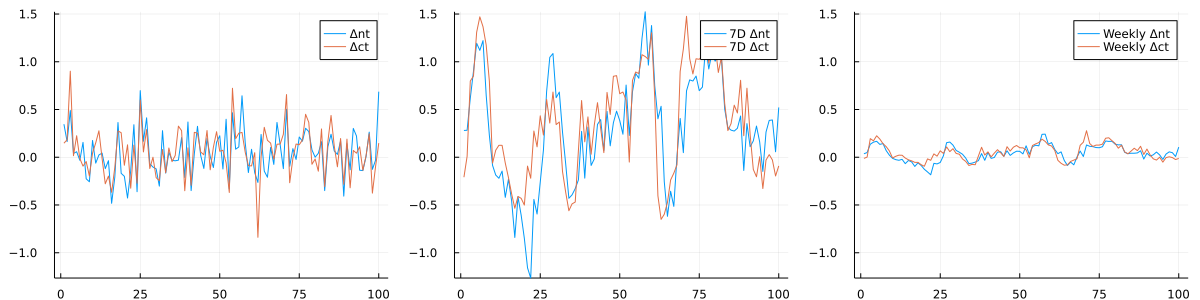

In [126]:
# show first 100 of simulated data
data4plot = data[1:100, :]
p7 = plot(data4plot.Δ7nt, label = "7D Δnt")
    plot!(data4plot.Δ7ct, label = "7D Δct");
p1 = plot(data4plot.Δnt, label = "Δnt")
    plot!(data4plot.Δct, label = "Δct");
pW = plot(data4plot.ΔWnt, label = "Weekly Δnt")
    plot!(data4plot.ΔWct, label = "Weekly Δct");
plot(p1, p7, pW, layout = (1, 3), size = (1200, 300), 
        ylim = (min(data4plot.Δ7nt...), max(data4plot.Δ7nt...)))

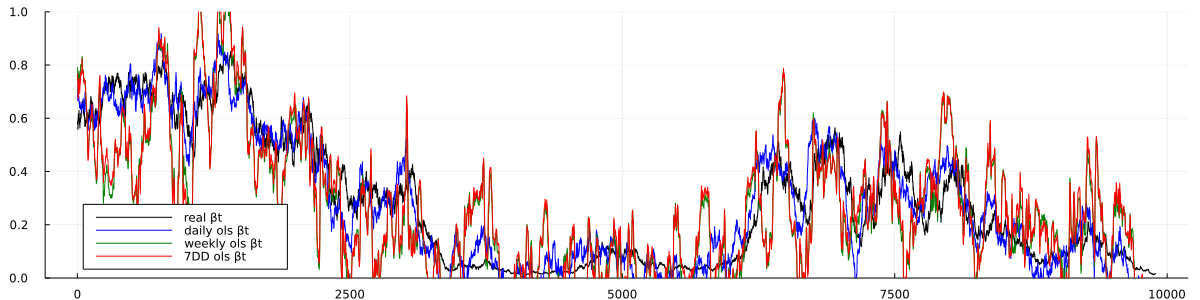

In [127]:
plot(truncate_β, color = :black, label = "real βt", ylim = (0,1), size = (1200, 300))
plot!(daily_β, color = :blue, label = "daily ols βt")
plot!(ww_β, color = :green, label = "weekly ols βt")
plot!(dd_β, color = :red, label = "7DD ols βt", leg = :bottomleft)
#png("1-sim_OLS_plot")

## Score

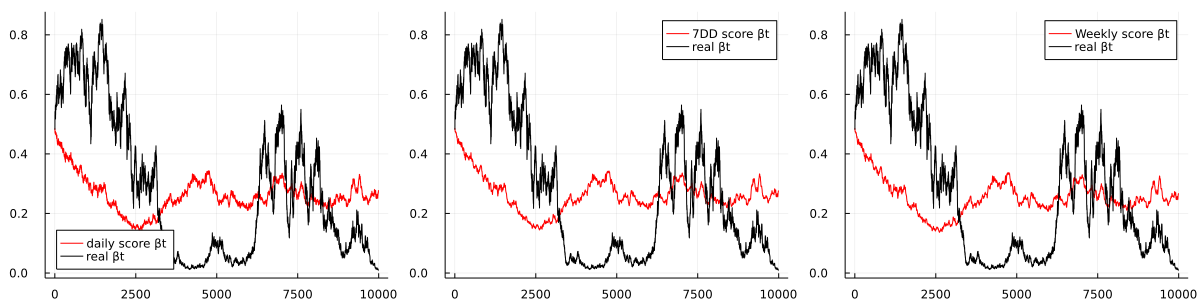

In [128]:
plot(scorep1, scorep2, scorep3, layout = (1, 3), size = (1200, 300))
#png("2-sim_score_plot")

# Simulate Errors

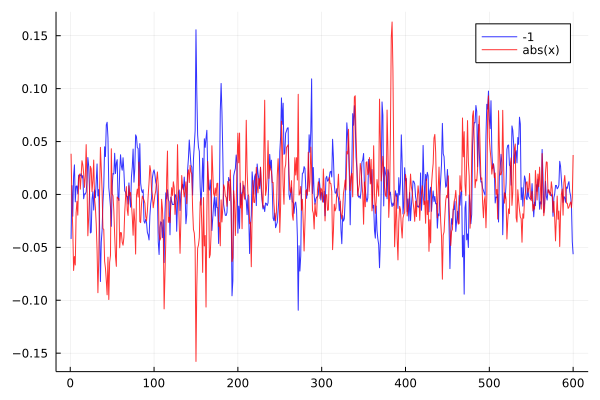

In [133]:
function simError(σx, T, σ, cov, α)
    d = MvNormal([0, 0], [σx^2 cov; cov σ^2])
    M = rand(d, T)
    Δnt = M[1, :]
    Ut = M[2, :]
    e0 = []
    e1 = []
    for k in 0:T-7
        v0 = (Ut[6 + k] * Δnt[6 + k] + 
            (Ut[6 + k] + Ut[5 + k]) * Δnt[5 + k] +
            (Ut[6 + k] + Ut[5 + k] + Ut[4 + k]) * Δnt[4 + k] +
            (Ut[6 + k] + Ut[5 + k] + Ut[4 + k] + Ut[3 + k]) * Δnt[3 + k] + 
            (Ut[6 + k] + Ut[5 + k] + Ut[4 + k] + Ut[3 + k] + Ut[2 + k]) * Δnt[2 + k] +
            (Ut[6 + k] + Ut[5 + k] + Ut[4 + k] + Ut[3 + k] + Ut[2 + k] + Ut[1 + k]) *
                 Δnt[1 + k]) * α / σ 
                  + sum(Ut[k + 1 : k + 7])

        v1 = (Ut[6 + k] * Δnt[6 + k] * sign(Δnt[6 + k]) + 
                 (Ut[6 + k] * sign(Δnt[6 + k]) + 
                     Ut[5 + k]) * sign(Δnt[5 + k]) * Δnt[5 + k] +
                 (Ut[6 + k] * sign(Δnt[6 + k]) + 
                     Ut[5 + k] * sign(Δnt[5 + k]) + 
                     Ut[4 + k]) * sign(Δnt[4 + k]) * Δnt[4 + k] +
                 (Ut[6 + k] * sign(Δnt[6 + k]) + 
                     Ut[5 + k] * sign(Δnt[5 + k]) + 
                     Ut[4 + k] * sign(Δnt[4 + k]) + 
                     Ut[3 + k] * sign(Δnt[3 + k])) * Δnt[3 + k] + 
                 (Ut[6 + k] * sign(Δnt[6 + k]) + 
                     Ut[5 + k] * sign(Δnt[5 + k]) + 
                     Ut[4 + k] * sign(Δnt[4 + k]) + 
                     Ut[3 + k] * sign(Δnt[3 + k]) + 
                     Ut[2 + k] * sign(Δnt[2 + k])) * Δnt[2 + k] +
                 (Ut[6 + k] * sign(Δnt[6 + k]) + 
                     Ut[5 + k] * sign(Δnt[5 + k]) + 
                     Ut[4 + k] * sign(Δnt[4 + k]) + 
                     Ut[3 + k] * sign(Δnt[3 + k]) + 
                     Ut[2 + k] * sign(Δnt[2 + k]) + 
                     Ut[1 + k] * sign(Δnt[1 + k])) * Δnt[1 + k]) * (-α) / σ 
                      + sum(Ut[k + 1 : k + 7])
        push!(e0, v0)
        push!(e1, v1)
    end
    return(e0, e1)
end

corr = 0  # density of error depends on this correlation 
σ = 0.2
σx = 0.25
α = 0.03
cov = corr * σx * σ
T = 1000000
e0, e1 = simError(σx, T, σ, cov, α);
plot(e0[1:600], label = "-1", color = :blue, alpha = 0.8)
    plot!(e1[1:600], label = "abs(x)", color = :red, alpha = 0.8)
#plot(p1, p2, layout = (1, 2))

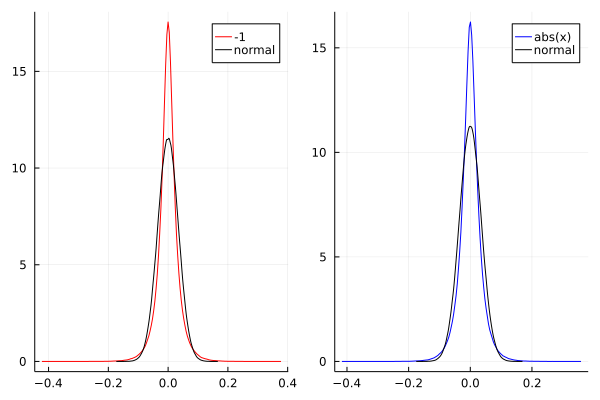

In [134]:
p1 = density(e0, label = "-1", color = :red)
    density!(rand(Normal(mean(e0), std(e0)), length(e0)), label = "normal", color = :black);
p2 = density(e1, label = "abs(x)", color = :blue)
    density!(rand(Normal(mean(e1), std(e1)), length(e1)), label = "normal", color = :black);
    plot(p1, p2, layout = (1, 2))
